In [62]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

### Load data

In [63]:
selection_df = pd.read_pickle('../data/selection_df.pkl')

In [64]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'total_points'], dtype='object')

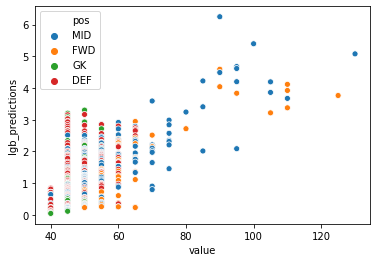

In [65]:
sns.scatterplot(data=selection_df,x='value',y='lgb_predictions',hue='pos')

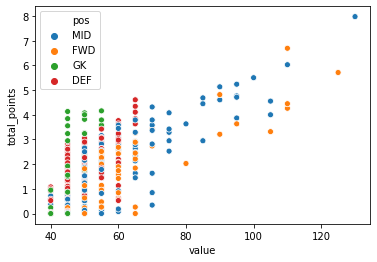

In [66]:
sns.scatterplot(data=selection_df,x='value',y='total_points',hue='pos')

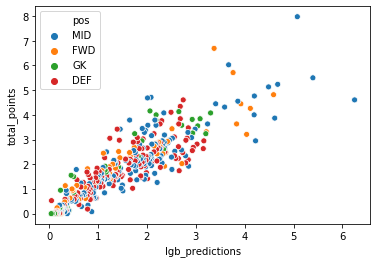

In [67]:
sns.scatterplot(data=selection_df,x='lgb_predictions',y='total_points',hue='pos')

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

In [68]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'total_points'], dtype='object')

In [69]:
selection_df = selection_df.loc[selection_df.total_points.notna(),:].reset_index(drop=True)

In [70]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 1000, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

manually removing Marhez, Courtois and Shaquiri (transfers)

In [71]:
selection_df = selection_df.loc[~selection_df.clean_name.isin(['Xherdan_Shaqiri','Riyad_Mahrez','Thibaut_Courtois']),:]

In [72]:
_, _, selections_prev_total = select_best_15(selection_df,'total_points')

In [73]:
_, _, selections_lgb = select_best_15(selection_df,'lgb_predictions')

In [74]:
def show_team(candidates, selection):
    position_map = {'GK':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.pos.map(position_map)
    return candidates.iloc[selection].sort_values(by='position_num').drop(columns='position_num')

In [75]:
selected_prev_total = show_team(selection_df,selections_prev_total); selected_prev_total

,clean_name,lgb_predictions,pos,value,total_points
26,Mathew_Ryan,3.087427,GK,45,3.842105
52,Lukasz_Fabianski,2.653311,GK,45,4.131579
28,Mathias_Jorgensen,3.025481,DEF,45,2.815789
37,Héctor_Bellerín,2.846600,DEF,55,3.473684
44,César_Azpilicueta,2.742325,DEF,65,4.605263
50,Marcos_Alonso,2.681571,DEF,65,4.342105
64,Nicolás_Otamendi,2.493071,DEF,65,4.105263
103,Luka_Milivojevic,2.162563,MID,65,3.789474
110,Fernando_Luiz Rosa,2.095063,MID,55,3.157895
17,Pascal_Groß,3.589609,MID,70,4.315789


In [76]:
selected_lgb = show_team(selection_df,selections_lgb); selected_lgb

,clean_name,lgb_predictions,pos,value,total_points
23,Ben_Foster,3.204635,GK,45,3.236842
26,Mathew_Ryan,3.087427,GK,45,3.842105
25,Shane_Duffy,3.152673,DEF,45,2.631579
28,Mathias_Jorgensen,3.025481,DEF,45,2.815789
30,Christopher_Schindler,2.948079,DEF,45,2.684211
33,Lewis_Dunk,2.929036,DEF,45,2.552632
38,Steve_Cook,2.845928,DEF,45,2.184211
0,Bamidele_Alli,6.248303,MID,90,4.605263
1,Kevin_De Bruyne,5.395278,MID,100,5.500000
17,Pascal_Groß,3.589609,MID,70,4.315789
